# Import Libraries

In [2]:
#Homemade Functions
from functions.functions_analysis import *
from functions.Path_combine_function import *
from functions.plot_functions import *
from functions.Preproc_functions import *

import matplotlib.pyplot as plt
import nibabel as nib

from nilearn import image as nli
from nilearn import plotting
import numpy as np
import time

import ants

from dipy.align.imwarp import SymmetricDiffeomorphicRegistration
from dipy.align import affine_registration, register_series, rigid, translation
from dipy.align.imaffine import AffineMap, AffineRegistration, MutualInformationMetric
from dipy.align.transforms import RigidTransform3D, TranslationTransform3D, AffineTransform3D
from dipy.data import fetch_stanford_hardi
from dipy.align.metrics import CCMetric

from dipy.io.image import load_nifti, save_nifti
from dipy.viz import regtools

from dipy.align.reslice import reslice

In [5]:
def evaluate_bias_field_correction(original_image = None, corrected_image = None, bias_field=None, xi = 180 , yi = 180, zi = 40):
    """
    Evaluate the bias field correction by comparing the original and corrected images.
    This function calculates the mean squared error (MSE) and displays both images.
    """
    original_data = original_image.numpy()
    corrected_data = corrected_image.numpy()

    # Calculate the mean squared error (MSE) between the original and corrected images
    mse = np.mean((original_data - corrected_data) ** 2)
    print(f"Mean Squared Error (MSE): {mse:.4f}")
    # Display the original and corrected images in sagittal and axial views

    ###### Display Xi ######
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[:, xi, :], cmap='gray')
    plt.title("Original (Coronal)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(corrected_image[:, xi, :], cmap='gray')
    plt.title("Corrected (Coronal)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(bias_field[:, xi, :], cmap='gray')
    plt.title("Bias Field (Coronal View)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    ###### Display zi ######
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[:, :, zi], cmap='gray')
    plt.title("Original (axial)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(corrected_image[:, :, zi], cmap='gray')
    plt.title("Corrected (axial)")
    plt.axis("off")

    plt.subplot(1,3,3)
    plt.imshow(bias_field[:, :, zi], cmap='gray')
    plt.title("Bias Field (Axial View)")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

    ###### Display yi ######
    plt.subplot(1, 3, 1)
    plt.imshow(original_image[yi, :], cmap='gray')
    plt.title("Original (Sagittal View)")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(corrected_image[yi, :], cmap='gray')
    plt.title("Corrected (Sagittal View)")
    plt.axis("off")


    plt.subplot(1,3,3)
    plt.imshow(bias_field[yi,:, :], cmap='gray')
    plt.title("Original (Sagittal View)")
    plt.axis("off")
    
    plt.tight_layout()
    plt.show()



    #### Compute mean intensity along z (slice axis) ####
    original_data = original_image.numpy()
    corrected_data = corrected_image.numpy()

    # Mean intensity along axes
    # Only calculate mean intensity on non-zero voxels for each slice
    mean_intensity_before = [
        original_data[:, :, z][original_data[:, :, z] > 0].mean() if np.any(original_data[:, :, z] > 0) else 0
        for z in range(original_data.shape[2])
    ]
    mean_intensity_after = [
        corrected_data[:, :, z][corrected_data[:, :, z] > 0].mean() if np.any(corrected_data[:, :, z] > 0) else 0
        for z in range(corrected_data.shape[2])
    ]
    mean_intensity_before_x = [
        original_data[x, :, :][original_data[x, :, :] > 0].mean() if np.any(original_data[x, :, :] > 0) else 0
        for x in range(original_data.shape[0])
    ]
    mean_intensity_after_x = [
        corrected_data[x, :, :][corrected_data[x, :, :] > 0].mean() if np.any(corrected_data[x, :, :] > 0) else 0
        for x in range(corrected_data.shape[0])
    ]
    mean_intensity_before_y = [
        original_data[:, y, :][original_data[:, y, :] > 0].mean() if np.any(original_data[:, y, :] > 0) else 0
        for y in range(original_data.shape[1])
    ]
    mean_intensity_after_y = [
        corrected_data[:, y, :][corrected_data[:, y, :] > 0].mean() if np.any(corrected_data[:, y, :] > 0) else 0
        for y in range(corrected_data.shape[1])
    ]

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(mean_intensity_before, label='Before', linestyle='--')
    plt.plot(mean_intensity_after, label='After', linestyle='-')
    plt.xlabel('Slice (z-axis)')
    plt.ylabel('Mean Intensity')
    plt.title('Mean Intensity (z-axis)')
    plt.legend()
    plt.grid()

    # Add vertical lines every 70th slice
    for x in range(0, len(mean_intensity_before), 70):
        plt.axvline(x=x, color='r', linestyle=':', alpha=0.5)

   

    plt.subplot(1, 3, 2)
    plt.plot(mean_intensity_before_x, label='Before', linestyle='--')
    plt.plot(mean_intensity_after_x, label='After', linestyle='-')
    plt.xlabel('Slice (x-axis)')
    plt.ylabel('Mean Intensity')
    plt.title('Mean Intensity (x-axis)')
    plt.legend()
    plt.grid()

    plt.subplot(1, 3, 3)
    plt.plot(mean_intensity_before_y, label='Before', linestyle='--')
    plt.plot(mean_intensity_after_y, label='After', linestyle='-')
    plt.xlabel('Slice (y-axis)')
    plt.ylabel('Mean Intensity')
    plt.title('Mean Intensity (y-axis)')
    plt.legend()
    plt.grid()

    plt.tight_layout()
    plt.show()

    # Coefficient of variation (CV) across slices

    cv_before = np.std(mean_intensity_before) / np.mean(mean_intensity_before)
    cv_after = np.std(mean_intensity_after) / np.mean(mean_intensity_after)
    print(f"CV before: {cv_before:.4f}, CV after: {cv_after:.4f}")


    # Histogram of intensities before and after correction
    # Flatten and remove zeros
    original_flat = original_data[original_data > 0].flatten()
    corrected_flat = corrected_data[corrected_data > 0].flatten()


    plt.hist(original_flat, bins=100, alpha=0.5, label='Before')
    plt.hist(corrected_flat, bins=100, alpha=0.5, label='After')
    plt.legend()
    plt.title("Histogram of Intensities")
    plt.show()
    
    return mse

In [4]:
info2 = np.load("Combined_Data/stitch_info_linear_blend.npy", allow_pickle= True)
info3 = np.load("Combined_Data/stitch_info_cosine_blend.npy", allow_pickle= True)

info4 = np.load("Combined_Data/stitch_info_BFC_cosine_blend.npy", allow_pickle= True)

In [5]:
print(f"info2_shape {info2.shape}, info3_shape {info3.shape}, info4_shape {info4.shape}")

info2_shape (28,), info3_shape (28,), info4_shape (28,)


# Registration Adapted with blending

In [4]:
def stitch_sections_with_weighted_blend(section_A_path, section_B_path, output_path,
                                         overlap_slices=10, margin_slices=2, trials=50, blend = 'linear'):
    """
    Stitches two spinal cord sections using multi-trial rigid registration on overlapping regions
    and performs a weighted blend of the overlapping region.

    Parameters:
        section_A_path (str): Path to the first section.
        section_B_path (str): Path to the second section.
        output_path (str): Path to save the stitched image.
        overlap_slices (int): Number of slices for overlap (default: 10).
        margin_slices (int): Displacement margin in slices.
        trials (int): Registration trials for robustness.
    """

    #################### Load images ###########################
    section_A = ants.image_read(section_A_path)
    section_B = ants.image_read(section_B_path)

    #section_B.set_spacing(section_A.spacing)
    #section_B.set_origin(section_A.origin)
    #section_B.set_direction(section_A.direction)

    best_mi = float(0)
    best_transform = None
    best_displacement = 0

    #################  Iterate over displacement windows within the margin ##########################
    for displacement in range(0, margin_slices + 1):
        print(f"Testing displacement: {displacement} slices")

        # Overlapping portions
        overlap_A_data = section_A.numpy()[:, :, :overlap_slices]

        start = -(overlap_slices + displacement)
        end = -displacement if displacement != 0 else None  # avoid -0 → 0 confusion
        overlap_B_data = section_B.numpy()[:, :, start:end]
        #overlap_B_data = section_B.numpy()[:, :, -(overlap_slices+displacement):-(displacement+1)]

        print(f"Overlap A shape: {overlap_A_data.shape}, Overlap B shape: {overlap_B_data.shape}")

        overlap_A = ants.from_numpy(overlap_A_data, origin=section_A.origin,
                                    spacing=section_A.spacing, direction=section_A.direction)
        overlap_B = ants.from_numpy(overlap_B_data, origin=section_B.origin,
                                    spacing=section_B.spacing, direction=section_B.direction)

        trial_mi_scores = []

        for i in range(trials):
            transform = ants.registration(fixed=overlap_A, moving=overlap_B, type_of_transform="Rigid")
            registered_B = ants.apply_transforms(fixed=overlap_A, moving=overlap_B,
                                                 transformlist=transform['fwdtransforms'])
            mi = ants.image_similarity(fixed_image=overlap_A, moving_image=registered_B,
                                       metric_type='MattesMutualInformation')
            trial_mi_scores.append(mi)

        mean_mi = np.mean(trial_mi_scores)
        print(f"Displacement {displacement}: Mean MI over {trials} trials = {mean_mi}")
        
        # Update best metrics
        if displacement == 0:
            best_mi = mean_mi
            best_transform = transform['fwdtransforms']
            best_displacement = displacement

        if mean_mi < best_mi:
            best_mi = mean_mi
            best_transform = transform['fwdtransforms']
            best_displacement = displacement

    print(f"Best displacement: {best_displacement} with mean MI = {best_mi}")


        
    ################ Register full section B to A ##########################
    registered_B = ants.apply_transforms(fixed=section_A, moving=section_B, transformlist=best_transform)
    print(f"Final registered_B.shape: {registered_B.shape}, section_A.shape: {section_A.shape}")

   
    end = -best_displacement if best_displacement != 0 else None  # avoid -0 → 0 confusion
    registered_B = section_B.numpy()[:, :, :end]



    mean_profile = np.mean(registered_B[:, 180, :], axis=0)
    zero_mean_indices = np.where(mean_profile != 0)[0]
    zB = max(zero_mean_indices) +1 

    registered_zB = registered_B[:, :, :zB]  # Keep only last Zb slices
    print(f"registered_zB.shape: {registered_zB.shape}, section_A.shape: {section_A.shape}")


    ################### Stitch the sections with weighted blend ###################
    # Prepare arrays
    A_array = section_A.numpy()
    B_array = registered_zB

    
    if blend == 'linear':
        # Weighted blend in the overlap
        weight_A = np.linspace(0, 1, overlap_slices).reshape(1, 1, -1)
        weight_B = 1 - weight_A

    if blend == 'cosine':
        # Cosine blend from 0 to 1 over overlap_slices
        z = np.linspace(0, np.pi, overlap_slices).reshape(1, 1, -1)
        weight_A = (1 - np.cos(z)) / 2 # 0 at the start, 1 at the end following a cosine curve 
        weight_B = 1 - weight_A  # Inverse of weight_A so it sums to 1. 


    A_overlap = A_array[:, :, :overlap_slices] * weight_A
    B_overlap = B_array[:, :, -overlap_slices:] * weight_B
    blended_overlap = A_overlap + B_overlap

    # Concatenate: A (non-overlap) + blended + B (non-overlap)
    stitched_data = np.concatenate([
        B_array[:, :, :-overlap_slices] , blended_overlap , A_array[:, :, overlap_slices:]
    ], axis=2)

    stitched_image = ants.from_numpy(stitched_data, origin=section_A.origin,
                                        spacing=section_A.spacing, direction=section_A.direction)



    ##### Save the stitched image and Registartion Info #####
    ants.image_write(stitched_image, output_path)
    print(f"Stitched image saved to {output_path}")


    # Ensure best_transform is a list of paths (usually one .mat file)
    transform_path = best_transform[0]

    # Read the transform from file
    rigid_transform = ants.read_transform(transform_path)

    # Extract 12 parameters: 9 for 3x3 matrix, 3 for translation
    params = rigid_transform.parameters  # list of 12 floats

    # Build full 4x4 affine matrix
    affine_4x4 = np.eye(4)
    affine_4x4[:3, :3] = np.array(params[:9]).reshape(3, 3)
    affine_4x4[:3, 3] = params[9:]



    # Create a named array (dictionary) with relevant values
    stitch_info = {
        'section_A_path': section_A_path,
        'section_B_path': section_B_path,
        'affine_path': transform_path,
        'affine_matrix': affine_4x4.tolist(),  # Convert to list for JSON serialization
        'zB': zB,
        'best_mi': best_mi,
        'best_displacement': best_displacement,
        'blend_type': blend,
        'overlap_slices': overlap_slices
    }


    return stitched_image, stitch_info


In [20]:
import numpy as np
def test(k,N):
    w_A = 1/2 * (1 - np.cos((np.pi*k)/(N)))
    return w_A
test(0,10)

np.float64(0.0)

In [ ]:
############## Stiching with Linear Blend ######################
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii") 

stitched_path = t2_paths[0]
stitch_info_list = []

for idx in range(1, len(t2_paths)):
    if idx == 1:
        stitched_output = f"Combined_data/stitched_preproc_weighted_blend_{idx}.nii.gz" # output path for the first stitch
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend(
            section_A_path=stitched_path,
            section_B_path=t2_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=20,
            blend='linear'  # Choose 'linear' or 'cosine' for blending
        )
    else:
        stitched_output = f"Combined_data/stitched_preproc_weighted_blend_{idx}.nii.gz" # Output path for subsequent stitches
        # Use the previous stitched image as section_A
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend(
            section_A_path = f"Combined_data/stitched_preproc_weighted_blend_{idx-1}.nii.gz",
            section_B_path = t2_paths[idx],
            output_path = stitched_output,
            overlap_slices = 10,
            margin_slices = 2,
            trials=20,
            blend='linear'  # Choose 'linear' or 'cosine' for blending
        )

    plt.imshow(stitched_image_trial[:, 180, :], cmap='gray')
    plt.title(f'Stitch {idx}')
    plt.show()
    stitched_path = stitched_output
    stitch_info_list.append(stitch_info)

np.save(f"Combined_data/stitch_info_linear_blend.npy", stitch_info_list)


In [ ]:
############## Stiching with Cosine Blend ######################
t2_paths = PathFinder("RARE_2D_Ax_preproc.nii") 

stitched_path = t2_paths[0]
stitch_info_list = []

for idx in range(1, len(t2_paths)):
    if idx == 1:
        stitched_output = f"Combined_data/stitched_preproc_cosine_weighted_blend_{idx}.nii.gz" # output path for the first stitch
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend(
            section_A_path=stitched_path,
            section_B_path=t2_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=10,
            blend='cosine'  # Use cosine blending
        )
    else:
        stitched_output = f"Combined_data/stitched_preproc_cosine_weighted_blend_{idx}.nii.gz" # Output path for subsequent stitches
        # Use the previous stitched image as section_A
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend(
            section_A_path= f"Combined_data/stitched_preproc_cosine_weighted_blend_{idx-1}.nii.gz",
            section_B_path= t2_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=10,
            blend='cosine'  # Use cosine blending
    )

    print(f"Stitched {idx}: {stitched_output}")
    if idx > 1:
        prev_path = f"Combined_data/stitched_preproc_cosine_weighted_blend_{idx-1}.nii.gz"
        if os.path.exists(prev_path):
            os.remove(prev_path)

    plt.imshow(stitched_image_trial[:, 180, :], cmap='gray')
    plt.title(f'Stitch {idx}')
    plt.show()
    stitched_path = stitched_output
    stitch_info_list.append(stitch_info)


np.save(f"Combined_data/stitch_info_cosine_blend.npy", stitch_info_list)

### Results and comparison of Registration & Brute Combinging

In [87]:
t2, affine = load_nifti('Combined_Data/Transposed/RARE_combined_trans.nii.gz') 
t2_blend, affine = load_nifti("Combined_Data/Transposed/RARE_preproc_combined_blend_trans.nii.gz")

t2_stitched_blend, affine = load_nifti("Combined_Data/stitched_preproc_cosine_weighted_blend_28.nii.gz")

In [97]:
print(f"t2_blend.shape: {t2_blend.shape}")
print(f"t2.shape: {t2.shape}")
print(f"t2_stitched_blend.shape: {t2_stitched_blend.shape}")

t2_blend.shape: (384, 384, 2040)
t2.shape: (384, 384, 1965)
t2_stitched_blend.shape: (384, 384, 1997)


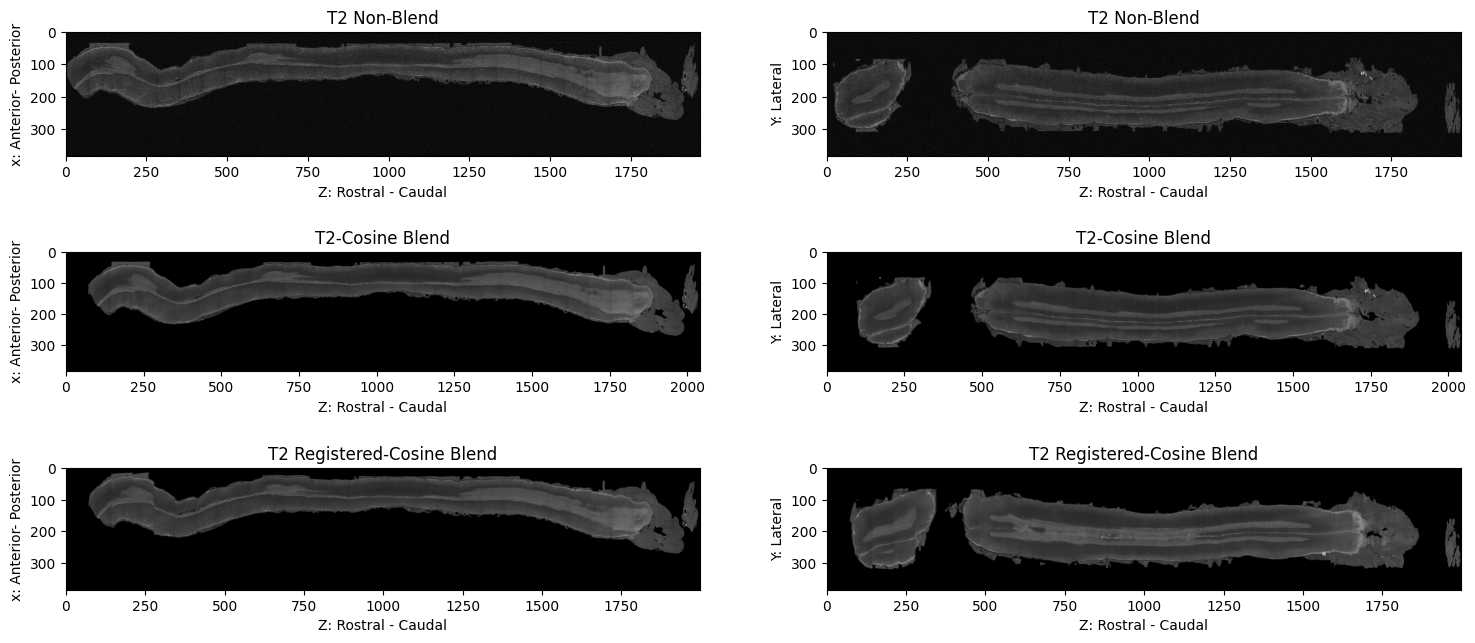

In [90]:
x = 80
y =  180
#Plot Saggital and Coronal Slices:
plt.figure(figsize=(18, 8))
plt.subplot(3, 2, 1)
plt.imshow(t2[:,y,:], cmap = "gray")
plt.ylabel("x: Anterior- Posterior")
plt.xlabel("Z: Rostral - Caudal")
plt.title("T2 Non-Blend")

plt.subplot(3, 2, 2)
plt.imshow(t2[x,:,:], cmap='gray')
plt.ylabel("Y: Lateral")
plt.xlabel("Z: Rostral - Caudal")
plt.title("T2 Non-Blend")

#Plot Saggital and Coronal Slices:
plt.subplot(3, 2, 3)
plt.imshow(t2_blend[:,y,:], cmap = "gray")
plt.ylabel("x: Anterior- Posterior")
plt.xlabel("Z: Rostral - Caudal")
plt.title("T2-Cosine Blend")

plt.subplot(3, 2, 4)
plt.imshow(t2_blend[x,:,:], cmap='gray')
plt.ylabel("Y: Lateral")
plt.xlabel("Z: Rostral - Caudal")
plt.title("T2-Cosine Blend")


#Plot Saggital and Coronal Slices:
plt.subplot(3, 2, 5)
plt.imshow(t2_stitched_blend[y,:,:], cmap = "gray")
plt.ylabel("x: Anterior- Posterior")
plt.xlabel("Z: Rostral - Caudal")
plt.title("T2 Registered-Cosine Blend")

plt.subplot(3, 2, 6)
plt.imshow(t2_stitched_blend[:,x,:], cmap='gray')
plt.ylabel("Y: Lateral")
plt.xlabel("Z: Rostral - Caudal")
plt.title("T2 Registered-Cosine Blend")


plt.show()




**Conclusion based on the images above:**

Combining using the brute force method is not worse than the use registration algorithm. The registration algorithm actually looks like it is fittig some noise. Especially around the sacral end of the spinal cord. Cosine blend is good for t2 weighted structural images to remove slab boundary effects but is bad for dwMRI as it may introduce artefacts in the fitting of ODF's. Caused by changes in intensity in the b0 images and bvec volumes that suddenly may no longer correspond to the correct anatomical location, as a result of averaging across possible different anatomical slices/voxels.   


In [11]:
import napari
full_combined_registered_cosine = ants.image_read("Combined_Data/stitched_preproc_cosine_weighted_blend_28.nii.gz")

full_combined_registered_cosine_numpy = full_combined_registered_cosine.numpy()

#napari.view_image(full_combined_registered_cosine_numpy, ndisplay=3)


# Display the spacing, shape, origin, and direction of the final stitched image
print(f"spacing of full_combined_registered_cosine: {full_combined_registered_cosine.spacing}, shape: {full_combined_registered_cosine.shape}, origin: {full_combined_registered_cosine.origin}, direction: {full_combined_registered_cosine.direction}")


spacing of full_combined_registered_cosine: (0.05000000074505806, 0.05000000074505806, 0.20000000298023224), shape: (384, 384, 1997), origin: (-9.600000381469727, 9.600000381469727, -7.900000095367432), direction: [[ 1.00000000e+00 -6.12323376e-17 -6.12323376e-17]
 [-6.12323376e-17 -1.00000000e+00 -4.19590793e-40]
 [ 6.12323376e-17 -3.74939943e-33  1.00000000e+00]]


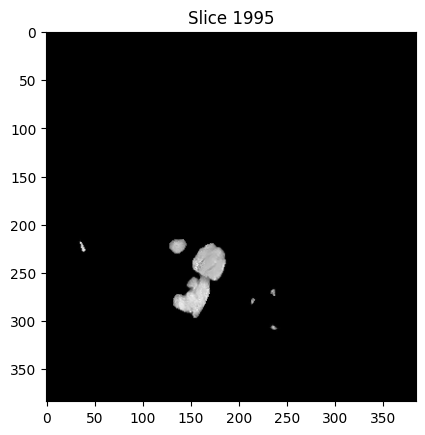

In [14]:
for z in range(100, full_combined_registered_cosine_numpy.shape[2], 5):
    plt.imshow(full_combined_registered_cosine_numpy[:, :, z], cmap='gray')
    plt.title(f'Slice {z}')
    plt.show()
    
    time.sleep(0.1)  # Small delay to avoid multiple triggers
    IPython.display.clear_output(wait=True)

# Bias Field Correction for Stitched 

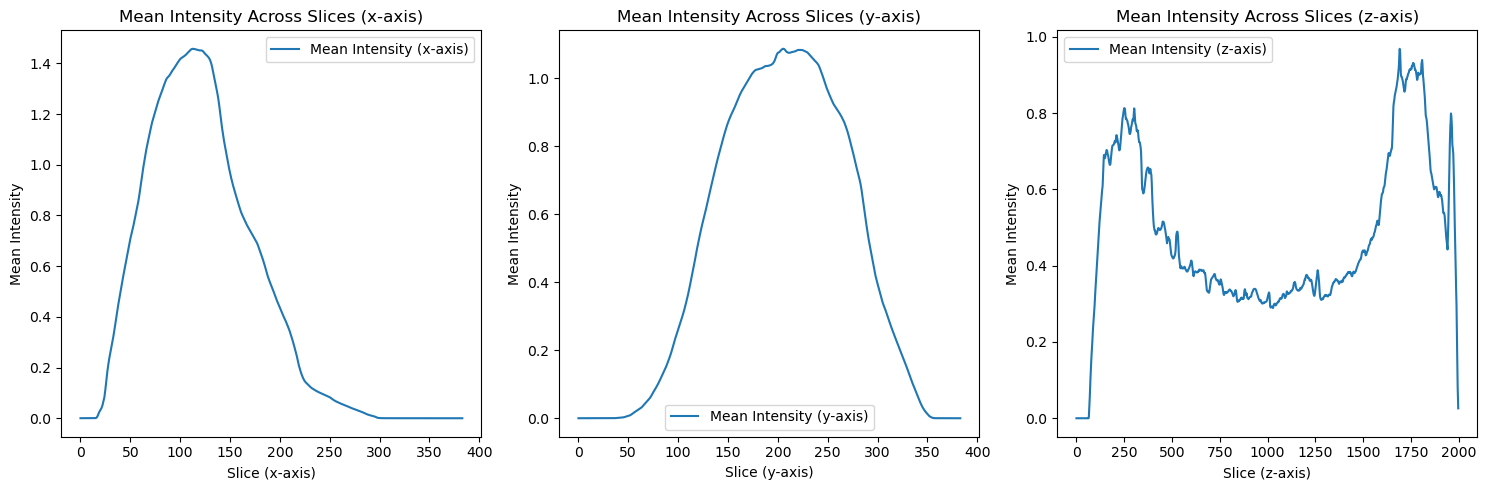

In [45]:
x_mean = np.mean(full_combined_registered_cosine_numpy, axis=(0,2))
z_mean = np.mean(full_combined_registered_cosine_numpy, axis=(0,1))
y_mean = np.mean(full_combined_registered_cosine_numpy, axis=(1,2))

plt.figure(figsize=(15, 5))
plt.subplot(1, 3, 1)
plt.plot(x_mean, label='Mean Intensity (x-axis)')
plt.xlabel('Slice (x-axis)')
plt.ylabel('Mean Intensity')
plt.title('Mean Intensity Across Slices (x-axis)')
plt.legend()
plt.subplot(1, 3, 2)
plt.plot(y_mean, label='Mean Intensity (y-axis)')
plt.xlabel('Slice (y-axis)')
plt.ylabel('Mean Intensity')
plt.title('Mean Intensity Across Slices (y-axis)')
plt.legend()
plt.subplot(1, 3, 3)
plt.plot(z_mean, label='Mean Intensity (z-axis)')
plt.xlabel('Slice (z-axis)')
plt.ylabel('Mean Intensity')
plt.title('Mean Intensity Across Slices (z-axis)')
plt.legend()
plt.tight_layout()
plt.show()

## Image info summary for Bias Field Correction:
Voxel spacing:

x, y = 0.05 mm
<!--  -->
z = 0.2 mm

Shape:

x, y = 384 → FOV = 384 × 0.05 = 19.2 mm

z = 1998 → FOV = 1998 × 0.2 = 399.6 mm




**B-spline:** Control Points Calculation

x/y = 5 mm → control points every 100 voxels (since 0.05 mm/voxel)

z = 50 mm → every 250 voxels (since 0.2 mm/voxel)

That gives:

~4 control points across 19.2 mm in x/y

~8 control points across 400 mm in z

In [ ]:
################ T2 IMAGE #######################
t2 = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz")


bias_field = ants.n4_bias_field_correction(t2,
                                                shrink_factor = 4,  # Adjust shrink factor for speed vs accuracy
                                                mask=None,  # Use the mask if available, or set to
                                                convergence= {'iters': [50,50,50,30], 'tol': 1e-6},                                                
                                                spline_param = 20 ,  # Adjust spline parameter for bias field smoothness
                                                return_bias_field= True,  # Set to True if you want to return the bias fieldias field
                                                verbose=False)  # Set to True for detailed output

RARE_corrected_full_combined_preproc_trans = t2 / bias_field

evaluate_bias_field_correction(original_image= t2, corrected_image=RARE_corrected_full_combined_preproc_trans, bias_field=bias_field, xi=180, yi=180, zi=40)

## Save Images
ants.image_write(RARE_corrected_full_combined_preproc_trans,
                 "Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")

ants.image_write(bias_field,
                 "Combined_Data/Rotated and Transposed/bias_field_RARE_combined_20.nii.gz")

In [ ]:
full_combined_registered_cosine = ants.image_read("C:\DTI_SC\humanSC_400h\Combined_Data\stitched_preproc_cosine_weighted_blend_28.nii.gz")


bias_field = ants.n4_bias_field_correction(full_combined_registered_cosine,
                                                shrink_factor = 1,  # Adjust shrink factor for speed vs accuracy
                                                mask=None,  # Use the mask if available, or set to
                                                convergence= {'iters': [50,50,50,30], 'tol': 1e-6},                                                
                                                spline_param =[2,2,2] ,  # Adjust spline parameter for bias field smoothness
                                                return_bias_field= True,  # Set to True if you want to return the bias fieldias field
                                                verbose=False)  # Set to True for detailed output

RARE_corrected_full_combined_registered_cosine = full_combined_registered_cosine / bias_field


ants.image_write(RARE_corrected_full_combined_registered_cosine, "C:\DTI_SC\humanSC_400h\Combined_Data\RARE_BFC_corrected_full_combined_registered_cosine.nii.gz")

ants.image_write(bias_field,"Combined_data/bias_field_RARE_full_registered_cosine_2_2_2.nii.gz")

Mean Squared Error (MSE): 0.0249


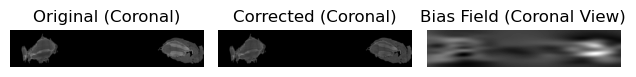

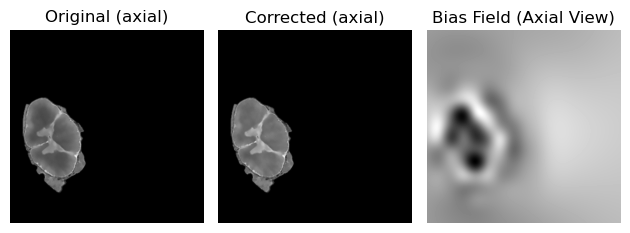

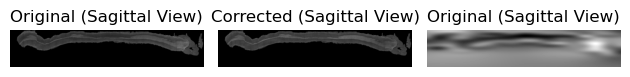

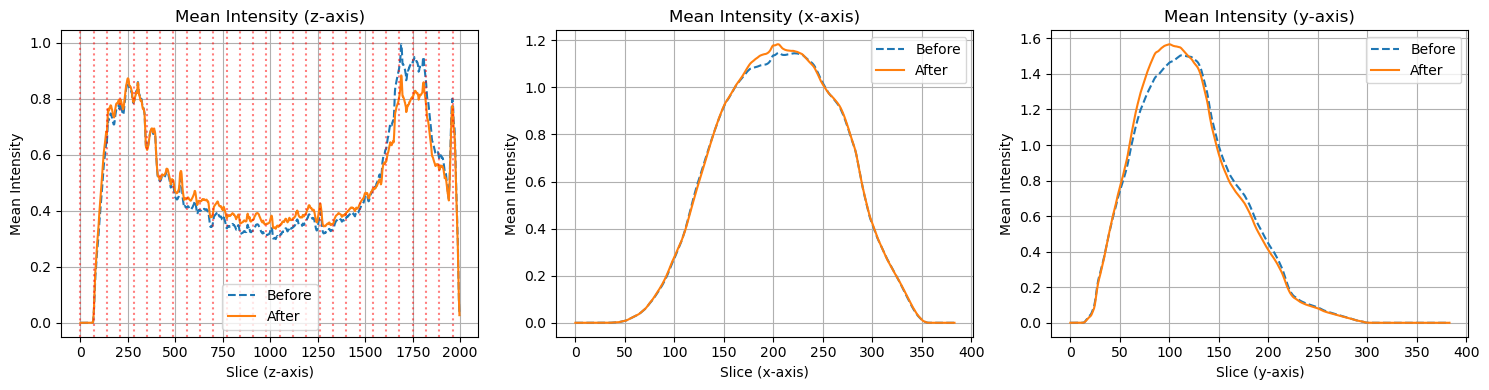

CV before: 0.4435, CV after: 0.3850


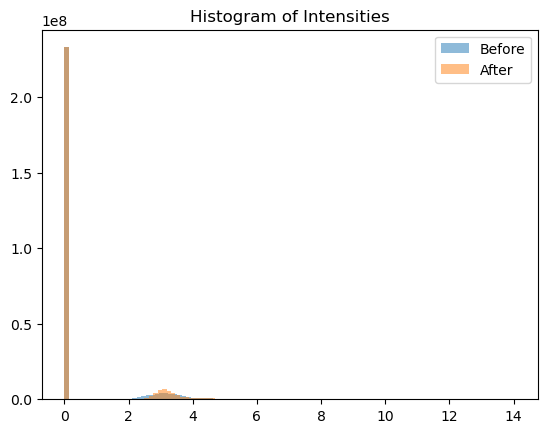

0.02493772

In [8]:
evaluate_bias_field_correction(
    original_image = full_combined_registered_cosine,
    corrected_image = RARE_corrected_full_combined_registered_cosine,
    bias_field = bias_field,
    xi=180,  # Coronal slice index
    yi=180,  # Sagittal slice index
    zi=1000    # Axial slice index
)

**Images that got Bias Field Corrected**

**WARNING**
We should perfrom Bias field correction after stiching the images together..... So this section is outdated and is not used

In [ ]:
############## Stiching with Cosine Blend ######################
t2_paths = PathFinder("RARE_2D_Ax_preproc_BFC.nii") 

stitched_path = t2_paths[0]
stitch_info_list = []

for idx in range(1, len(t2_paths)):
    if idx == 1:
        stitched_output = f"Combined_data/stitched_preproc_BFC_cosine_weighted_blend_{idx}.nii.gz" # output path for the first stitch
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend(
            section_A_path=stitched_path,
            section_B_path=t2_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=20,
            blend='cosine'  # Use cosine blending
        )
    else:
        stitched_output = f"Combined_data/stitched_preproc_BFC_cosine_weighted_blend_{idx}.nii.gz" # Output path for subsequent stitches
        # Use the previous stitched image as section_A
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend(
            section_A_path= f"Combined_data/stitched_preproc_BFC_cosine_weighted_blend_{idx-1}.nii.gz",
            section_B_path= t2_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=20,
            blend='cosine'  # Use cosine blending
        )
    print(f"Stitched {idx}: {stitched_output}")
    if idx > 1:
        prev_path = f"Combined_data/stitched_preproc_BFC_cosine_weighted_blend_{idx-1}.nii.gz"
        if os.path.exists(prev_path):
            os.remove(prev_path)

    plt.imshow(stitched_image_trial[:, 180, :], cmap='gray')
    plt.title(f'Stitch {idx}')
    plt.show()
    stitched_path = stitched_output
    stitch_info_list.append(stitch_info)


    np.save(f"Combined_data/stitch_info_BFC_cosine_blend.npy", stitch_info_list)

In [2]:
image = ants.image_read("Combined_data/stitched_preproc_BFC_cosine_weighted_blend_28.nii.gz")

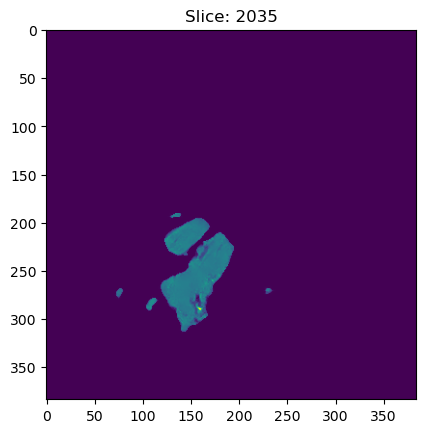

In [4]:
plot_all_slices(image, pause = .1, increment = 5)

# Registration of dwMRI

In [42]:
def stitch_sections_with_weighted_blend_dwMRI(section_A_path, section_B_path, output_path,
                                         overlap_slices=10, margin_slices=2, trials=50, blend = 'linear'):
    """
    Stitches two spinal cord sections using multi-trial rigid registration on overlapping regions
    and performs a weighted blend of the overlapping region.

    Parameters:
        section_A_path (str): Path to the first section.
        section_B_path (str): Path to the second section.
        output_path (str): Path to save the stitched image.
        overlap_slices (int): Number of slices for overlap (default: 10).
        margin_slices (int): Displacement margin in slices.
        trials (int): Registration trials for robustness.
    """

    #################### (1) Load images ###########################
    section_A = ants.image_read(section_A_path)
    section_B = ants.image_read(section_B_path)

    Section_A_b0 = section_A[:,:,:,0:3]
    Section_B_b0 = section_B[:,:,:,0:3]

    
    Section_A_b0 = np.mean(Section_A_b0, axis=3)
    Section_B_b0 = np.mean(Section_B_b0, axis=3)

    direction_clean_A = np.array(section_A.direction[:3, :3], dtype=np.float64, order='C')
    direction_clean_B = np.array(section_B.direction[:3, :3], dtype=np.float64, order='C')


    best_mi = float(0)
    best_transform = None
    best_displacement = 0

    ################# (2) Iterate over displacement windows within the margin ##########################
    for displacement in range(0, margin_slices + 1):
        print(f"Testing displacement: {displacement} slices")

        ### Overlap A data ###
        overlap_A_data = Section_A_b0[:, :, :overlap_slices]

        ### Overlap B data with displacement ###
        start = -(overlap_slices + displacement)
        end = -displacement if displacement != 0 else None  # avoid -0 → 0 confusion
        overlap_B_data = Section_B_b0[:, :, start:end]
        
        print(f"Overlap A shape: {overlap_A_data.shape}, Overlap B shape: {overlap_B_data.shape}")

        overlap_A = ants.from_numpy(overlap_A_data, 
                                    origin=section_A.origin[:3],
                                    spacing=section_A.spacing[:3], 
                                    direction= direction_clean_A)
        
        overlap_B = ants.from_numpy(overlap_B_data,
                                    origin=section_B.origin[:3],
                                    spacing=section_B.spacing[:3],
                                    direction=direction_clean_B)
        
        ############# (3) Start multi-trial registration ##########################
        trial_mi_scores = []
        for i in range(trials):
            transform = ants.registration(fixed=overlap_A, moving=overlap_B, type_of_transform="Rigid")
            registered_B = ants.apply_transforms(fixed=overlap_A, moving=overlap_B,
                                                 transformlist=transform['fwdtransforms'])
            mi = ants.image_similarity(fixed_image=overlap_A, moving_image=registered_B,
                                       metric_type='MattesMutualInformation')
            trial_mi_scores.append(mi)

        mean_mi = np.mean(trial_mi_scores)
        print(f"Displacement {displacement}: Mean MI over {trials} trials = {mean_mi}")
        
        # Update best metrics
        if displacement == 0:
            best_mi = mean_mi
            best_transform = transform['fwdtransforms']
            best_displacement = displacement

        if mean_mi < best_mi:
            best_mi = mean_mi
            best_transform = transform['fwdtransforms']
            best_displacement = displacement

    print(f"Best displacement: {best_displacement} with mean MI = {best_mi}")


        
    ################ (4) Register full section B to A ##########################
    dwMRI_registered_volumes = []
    for i in range(section_A.shape[3]):
        vol_A = section_A[:,:,:,i]
        vol_B = section_B[:,:,:,i]

        vol_A = ants.from_numpy(
            vol_A,
            origin=section_A.origin[:3],
            spacing=section_A.spacing[:3],
            direction=direction_clean_A
        )
        vol_B = ants.from_numpy(
            vol_B,
            origin=section_B.origin[:3],
            spacing=section_B.spacing[:3],
            direction=direction_clean_B
        )

        # Apply the best transform to each volume
        vol_registered = ants.apply_transforms(
            fixed=vol_A,
            moving=vol_B,
            transformlist=transform['fwdtransforms'],
            interpolator='linear'  # Use linear interpolation for DWI
        )
        dwMRI_registered_volumes.append(vol_registered.numpy())

    # Stack into a new 4D volume
    dwi_registered_4d = np.stack(dwMRI_registered_volumes, axis=3)

    # Convert back to ANTsImage
    registered_B = ants.from_numpy(
        dwi_registered_4d,
        origin= section_A.origin,
        spacing=section_A.spacing,
        direction=section_A.direction)
    
    #registered_B = ants.apply_transforms(fixed=section_A, moving=section_B, transformlist=best_transform)
    #print(f"Final registered_B.shape: {registered_B.shape}, section_A.shape: {section_A.shape}")

    # Include the best displacement
    end = -best_displacement if best_displacement != 0 else None  # avoid -0 → 0 confusion
    registered_B = registered_B.numpy()[:, :, :end]

    mean_profile = np.mean(registered_B[:, 50, :, 0], axis=0)
    plt.imshow(registered_B[:, 50, :, 0], cmap = "gray")
    plt.title(f"Plot of Registered B for idx{section_B_path}")
    plt.show()

    print(f"Mean profile shape: {mean_profile.shape}")
    zero_mean_indices = np.where(mean_profile != 0)[0]
    zB = max(zero_mean_indices) +1 

    registered_zB = registered_B[:, :, :zB,:]  # Keep only last Zb slices
    print(f"registered_zB.shape: {registered_zB.shape}, section_A.shape: {section_A.shape}")


    ################### (5) Stitch the sections with weighted blend ###################
    # Prepare arrays
    A_array = section_A.numpy()
    B_array = registered_zB

    
    if blend == 'linear':
        # Weighted blend in the overlap
        weight_A = np.linspace(0, 1, overlap_slices).reshape(1, 1, -1,1)
        weight_B = 1 - weight_A

    if blend == 'cosine':
        # Cosine blend from 0 to 1 over overlap_slices
        z = np.linspace(0, np.pi, overlap_slices).reshape(1, 1, -1,1)
        weight_A = (1 - np.cos(z)) / 2 # 0 at the start, 1 at the end following a cosine curve 
        weight_B = 1 - weight_A  # Inverse of weight_A so it sums to 1. 


    A_overlap = A_array[:, :, :overlap_slices,:] * weight_A
    B_overlap = B_array[:, :, -overlap_slices:,:] * weight_B
    blended_overlap = A_overlap + B_overlap

    # Concatenate: A (non-overlap) + blended + B (non-overlap)
    stitched_data = np.concatenate([
        B_array[:, :, :-overlap_slices,:] , blended_overlap , A_array[:, :, overlap_slices:,:]
    ], axis=2)

    stitched_image = ants.from_numpy(stitched_data, origin=section_A.origin,
                                        spacing=section_A.spacing, direction=section_A.direction)


    ############### (6) Save the stitched image and create stitch info ##################
    ants.image_write(stitched_image, output_path)
    print(f"Stitched image saved to {output_path}")

    # Ensure best_transform is a list of paths (usually one .mat file)
    transform_path = best_transform[0]

    # Read the transform from file
    rigid_transform = ants.read_transform(transform_path)

    # Extract 12 parameters: 9 for 3x3 matrix, 3 for translation
    params = rigid_transform.parameters  # list of 12 floats

    # Build full 4x4 affine matrix
    affine_4x4 = np.eye(4)
    affine_4x4[:3, :3] = np.array(params[:9]).reshape(3, 3)
    affine_4x4[:3, 3] = params[9:]



    # Create a named array (dictionary) with relevant values
    stitch_info = {
        'section_A_path': section_A_path,
        'section_B_path': section_B_path,
        'affine_path': transform_path,
        'affine_matrix': affine_4x4.tolist(),  # Convert to list for JSON serialization
        'zB': zB,
        'best_mi': best_mi,
        'best_displacement': best_displacement,
        'blend_type': blend,
        'overlap_slices': overlap_slices
    }
    return stitched_image, stitch_info

In [ ]:
dwMRI_paths = PathFinder("gibbs_denoised_affine_ok.nii") 

section_A_path = dwMRI_paths[0]
section_B_path = dwMRI_paths[1]
margin_slices = 2
overlap_slices = 10
trials = 20 
blend = "cosine"

output_path = "test1.nii.gz"

#################### (1) Load images ###########################
section_A = ants.image_read(section_A_path)
section_B = ants.image_read(section_B_path)


#Section_A_b0 = section_A[:,:,:,0]
#Section_B_b0 = section_B[:,:,:,0]

## Using Mean b0
Section_A_b0 = section_A[:,:,:,0:3]
Section_B_b0 = section_B[:,:,:,0:3]

Section_A_b0 = np.mean(Section_A_b0, axis=3)
Section_B_b0 = np.mean(Section_B_b0, axis=3)

direction_clean_A = np.array(section_A.direction[:3, :3], dtype=np.float64, order='C')
direction_clean_B = np.array(section_B.direction[:3, :3], dtype=np.float64, order='C')


best_mi = float(0)
best_transform = None
best_displacement = 0

################# (2) Iterate over displacement windows within the margin ##########################
for displacement in range(0, margin_slices + 1):
    print(f"Testing displacement: {displacement} slices")

    ### Overlap A data ###
    overlap_A_data = Section_A_b0[:, :, :overlap_slices]

    ### Overlap B data with displacement ###
    start = -(overlap_slices + displacement)
    end = -displacement if displacement != 0 else None  # avoid -0 → 0 confusion
    overlap_B_data = Section_B_b0[:, :, start:end]
    
    print(f"Overlap A shape: {overlap_A_data.shape}, Overlap B shape: {overlap_B_data.shape}")

    overlap_A = ants.from_numpy(overlap_A_data, 
                                origin=section_A.origin[:3],
                                spacing=section_A.spacing[:3], 
                                direction= direction_clean_A)
    
    overlap_B = ants.from_numpy(overlap_B_data,
                                origin=section_B.origin[:3],
                                spacing=section_B.spacing[:3],
                                direction=direction_clean_B)
    
############# (3) Start multi-trial registration ##########################
    trial_mi_scores = []
    for i in range(trials):
        transform = ants.registration(fixed=overlap_A, moving=overlap_B, type_of_transform="Rigid")
        registered_B = ants.apply_transforms(fixed=overlap_A, moving=overlap_B,
                                                transformlist=transform['fwdtransforms'])
        mi = ants.image_similarity(fixed_image=overlap_A, moving_image=registered_B,
                                    metric_type='MattesMutualInformation')
        trial_mi_scores.append(mi)

    mean_mi = np.mean(trial_mi_scores)
    print(f"Displacement {displacement}: Mean MI over {trials} trials = {mean_mi}")
    
    # Update best metrics
    if displacement == 0:
        best_mi = mean_mi
        best_transform = transform['fwdtransforms']
        best_displacement = displacement

    if mean_mi < best_mi:
        best_mi = mean_mi
        best_transform = transform['fwdtransforms']
        best_displacement = displacement

print(f"Best displacement: {best_displacement} with mean MI = {best_mi}")


    
################ (4) Register full section B to A ##########################
dwMRI_registered_volumes = []
for i in range(section_A.shape[3]):
    vol_A = section_A[:,:,:,i]
    vol_B = section_B[:,:,:,i]

    vol_A = ants.from_numpy(
        vol_A,
        origin=section_A.origin[:3],
        spacing=section_A.spacing[:3],
        direction=direction_clean_A
    )
    vol_B = ants.from_numpy(
        vol_B,
        origin=section_B.origin[:3],
        spacing=section_B.spacing[:3],
        direction=direction_clean_B
    )

    # Apply the best transform to each volume
    vol_registered = ants.apply_transforms(
        fixed=vol_A,
        moving=vol_B,
        transformlist=transform['fwdtransforms'],
        interpolator='linear'  # Use linear interpolation for DWI
    )
    dwMRI_registered_volumes.append(vol_registered.numpy())

# Stack into a new 4D volume
dwi_registered_4d = np.stack(dwMRI_registered_volumes, axis=3)

# Convert back to ANTsImage
registered_B = ants.from_numpy(
    dwi_registered_4d,
    origin= section_A.origin,
    spacing=section_A.spacing,
    direction=section_A.direction)

#registered_B = ants.apply_transforms(fixed=section_A, moving=section_B, transformlist=best_transform)
#print(f"Final registered_B.shape: {registered_B.shape}, section_A.shape: {section_A.shape}")


mean_profile = np.mean(registered_B[:, :, :, 0], axis=(0,1))
plt.imshow(registered_B[50, :, :, 0], cmap = "gray")
plt.title(f"Plot of Registered B for idx{section_B_path}")
plt.show()

print(f"Mean profile shape: {mean_profile.shape}")
zero_mean_indices = np.where(mean_profile != 0)[0]
zB = max(zero_mean_indices) +1 

registered_zB = registered_B[:, :, :zB,:]  # Keep only last Zb slices
print(f"registered_zB.shape: {registered_zB.shape}, section_A.shape: {section_A.shape}")


################### (5) Stitch the sections with weighted blend ###################
# Prepare arrays
A_array = section_A.numpy()
B_array = registered_zB


if blend == 'linear':
    # Weighted blend in the overlap
    weight_A = np.linspace(0, 1, overlap_slices).reshape(1, 1, -1,1)
    weight_B = 1 - weight_A

if blend == 'cosine':
    # Cosine blend from 0 to 1 over overlap_slices
    z = np.linspace(0, np.pi, overlap_slices).reshape(1, 1, -1,1)
    weight_A = (1 - np.cos(z)) / 2 # 0 at the start, 1 at the end following a cosine curve 
    weight_B = 1 - weight_A  # Inverse of weight_A so it sums to 1. 


A_overlap = A_array[:, :, :overlap_slices,:] * weight_A
B_overlap = B_array[:, :, -overlap_slices:,:] * weight_B
blended_overlap = A_overlap + B_overlap

# Concatenate: A (non-overlap) + blended + B (non-overlap)
stitched_data = np.concatenate([
    B_array[:, :, :-overlap_slices,:] , blended_overlap , A_array[:, :, overlap_slices:,:]
], axis=2)

stitched_image = ants.from_numpy(stitched_data, origin=section_A.origin,
                                    spacing=section_A.spacing, direction=section_A.direction)


############### (6) Save the stitched image and create stitch info ##################
ants.image_write(stitched_image, output_path)
print(f"Stitched image saved to {output_path}")

# Ensure best_transform is a list of paths (usually one .mat file)
transform_path = best_transform[0]

# Read the transform from file
rigid_transform = ants.read_transform(transform_path)

# Extract 12 parameters: 9 for 3x3 matrix, 3 for translation
params = rigid_transform.parameters  # list of 12 floats

# Build full 4x4 affine matrix
affine_4x4 = np.eye(4)
affine_4x4[:3, :3] = np.array(params[:9]).reshape(3, 3)
affine_4x4[:3, 3] = params[9:]



# Create a named array (dictionary) with relevant values
stitch_info = {
    'section_A_path': section_A_path,
    'section_B_path': section_B_path,
    'affine_path': transform_path,
    'affine_matrix': affine_4x4.tolist(),  # Convert to list for JSON serialization
    'zB': zB,
    'best_mi': best_mi,
    'best_displacement': best_displacement,
    'blend_type': blend,
    'overlap_slices': overlap_slices
}


In [ ]:
dwMRI_paths = PathFinder("gibbs_denoised_affine_ok.nii") 

section_A_path = "test1.nii.gz"
section_B_path = dwMRI_paths[2]
margin_slices = 2
overlap_slices = 10
trials = 20 
blend = "cosine"

output_path = "test2.nii.gz"

#################### (1) Load images ###########################
section_A = ants.image_read(section_A_path)
section_B = ants.image_read(section_B_path)


#Section_A_b0 = section_A[:,:,:,0]
#Section_B_b0 = section_B[:,:,:,0]

## Using Mean b0
Section_A_b0 = section_A[:,:,:,0:3]
Section_B_b0 = section_B[:,:,:,0:3]

Section_A_b0 = np.mean(Section_A_b0, axis=3)
Section_B_b0 = np.mean(Section_B_b0, axis=3)

direction_clean_A = np.array(section_A.direction[:3, :3], dtype=np.float64, order='C')
direction_clean_B = np.array(section_B.direction[:3, :3], dtype=np.float64, order='C')


best_mi = float(0)
best_transform = None
best_displacement = 0

################# (2) Iterate over displacement windows within the margin ##########################
for displacement in range(0, margin_slices + 1):
    print(f"Testing displacement: {displacement} slices")

    ### Overlap A data ###
    overlap_A_data = Section_A_b0[:, :, :overlap_slices]

    ### Overlap B data with displacement ###
    start = -(overlap_slices + displacement)
    end = -displacement if displacement != 0 else None  # avoid -0 → 0 confusion
    overlap_B_data = Section_B_b0[:, :, start:end]
    
    print(f"Overlap A shape: {overlap_A_data.shape}, Overlap B shape: {overlap_B_data.shape}")

    overlap_A = ants.from_numpy(overlap_A_data, 
                                origin=section_A.origin[:3],
                                spacing=section_A.spacing[:3], 
                                direction= direction_clean_A)
    
    overlap_B = ants.from_numpy(overlap_B_data,
                                origin=section_B.origin[:3],
                                spacing=section_B.spacing[:3],
                                direction=direction_clean_B)
    
############# (3) Start multi-trial registration ##########################
    trial_mi_scores = []
    for i in range(trials):
        transform = ants.registration(fixed=overlap_A, moving=overlap_B, type_of_transform="Rigid")
        registered_B = ants.apply_transforms(fixed=overlap_A, moving=overlap_B,
                                                transformlist=transform['fwdtransforms'])
        mi = ants.image_similarity(fixed_image=overlap_A, moving_image=registered_B,
                                    metric_type='MattesMutualInformation')
        trial_mi_scores.append(mi)

    mean_mi = np.mean(trial_mi_scores)
    print(f"Displacement {displacement}: Mean MI over {trials} trials = {mean_mi}")
    
    # Update best metrics
    if displacement == 0:
        best_mi = mean_mi
        best_transform = transform['fwdtransforms']
        best_displacement = displacement

    if mean_mi < best_mi:
        best_mi = mean_mi
        best_transform = transform['fwdtransforms']
        best_displacement = displacement

print(f"Best displacement: {best_displacement} with mean MI = {best_mi}")


    
################ (4) Register full section B to A ##########################
dwMRI_registered_volumes = []
for i in range(section_A.shape[3]):
    vol_A = section_A[:,:,:,i]
    vol_B = section_B[:,:,:,i]

    vol_A = ants.from_numpy(
        vol_A,
        origin=section_A.origin[:3],
        spacing=section_A.spacing[:3],
        direction=direction_clean_A
    )
    vol_B = ants.from_numpy(
        vol_B,
        origin=section_B.origin[:3],
        spacing=section_B.spacing[:3],
        direction=direction_clean_B
    )

    # Apply the best transform to each volume
    vol_registered = ants.apply_transforms(
        fixed=vol_A,
        moving=vol_B,
        transformlist=transform['fwdtransforms'],
        interpolator='linear'  # Use linear interpolation for DWI
    )
    dwMRI_registered_volumes.append(vol_registered.numpy())

# Stack into a new 4D volume
dwi_registered_4d = np.stack(dwMRI_registered_volumes, axis=3)

# Convert back to ANTsImage
registered_B = ants.from_numpy(
    dwi_registered_4d,
    origin= section_A.origin,
    spacing=section_A.spacing,
    direction=section_A.direction)

#registered_B = ants.apply_transforms(fixed=section_A, moving=section_B, transformlist=best_transform)
#print(f"Final registered_B.shape: {registered_B.shape}, section_A.shape: {section_A.shape}")


mean_profile = np.mean(registered_B[:, :, :, 0], axis=(0,1))
plt.imshow(registered_B[50, :, :, 0], cmap = "gray")
plt.title(f"Plot of Registered B for idx{section_B_path}")
plt.show()

print(f"Mean profile shape: {mean_profile.shape}")
zero_mean_indices = np.where(mean_profile != 0)[0]
zB = max(zero_mean_indices) +1 

registered_zB = registered_B[:, :, :zB,:]  # Keep only last Zb slices
print(f"registered_zB.shape: {registered_zB.shape}, section_A.shape: {section_A.shape}")


################### (5) Stitch the sections with weighted blend ###################
# Prepare arrays
A_array = section_A.numpy()
B_array = registered_zB


if blend == 'linear':
    # Weighted blend in the overlap
    weight_A = np.linspace(0, 1, overlap_slices).reshape(1, 1, -1,1)
    weight_B = 1 - weight_A

if blend == 'cosine':
    # Cosine blend from 0 to 1 over overlap_slices
    z = np.linspace(0, np.pi, overlap_slices).reshape(1, 1, -1,1)
    weight_A = (1 - np.cos(z)) / 2 # 0 at the start, 1 at the end following a cosine curve 
    weight_B = 1 - weight_A  # Inverse of weight_A so it sums to 1. 


A_overlap = A_array[:, :, :overlap_slices,:] * weight_A
B_overlap = B_array[:, :, -overlap_slices:,:] * weight_B
blended_overlap = A_overlap + B_overlap

# Concatenate: A (non-overlap) + blended + B (non-overlap)
stitched_data = np.concatenate([
    B_array[:, :, :-overlap_slices,:] , blended_overlap , A_array[:, :, overlap_slices:,:]
], axis=2)

stitched_image = ants.from_numpy(stitched_data, origin=section_A.origin,
                                    spacing=section_A.spacing, direction=section_A.direction)


############### (6) Save the stitched image and create stitch info ##################
ants.image_write(stitched_image, output_path)
print(f"Stitched image saved to {output_path}")

# Ensure best_transform is a list of paths (usually one .mat file)
transform_path = best_transform[0]

# Read the transform from file
rigid_transform = ants.read_transform(transform_path)

# Extract 12 parameters: 9 for 3x3 matrix, 3 for translation
params = rigid_transform.parameters  # list of 12 floats

# Build full 4x4 affine matrix
affine_4x4 = np.eye(4)
affine_4x4[:3, :3] = np.array(params[:9]).reshape(3, 3)
affine_4x4[:3, 3] = params[9:]



# Create a named array (dictionary) with relevant values
stitch_info = {
    'section_A_path': section_A_path,
    'section_B_path': section_B_path,
    'affine_path': transform_path,
    'affine_matrix': affine_4x4.tolist(),  # Convert to list for JSON serialization
    'zB': zB,
    'best_mi': best_mi,
    'best_displacement': best_displacement,
    'blend_type': blend,
    'overlap_slices': overlap_slices
}


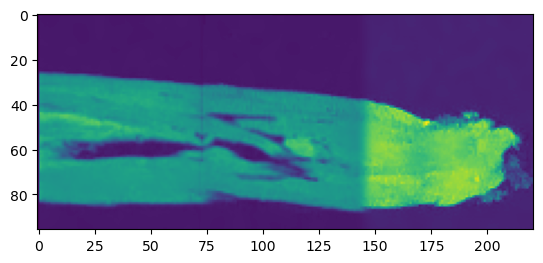

In [116]:
plt.imshow(stitched_image[:,50,:,0])

In [ ]:
dwMRI_paths = PathFinder("DTI_SE_BFC_gibbs_denoised_affine_ok.nii.gz") 

stitched_path = dwMRI_paths[0]

idx = 1 
stitched_output = f"Combined_data/stitched_preproc_BFC_cosine_weighted_blend_{idx}.nii.gz" # output path for the first stitch

stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend_dwMRI(
    section_A_path= dwMRI_paths[0],
    section_B_path= dwMRI_paths[1],
    output_path=stitched_output,
    overlap_slices=10,
    margin_slices=2,
    trials=20,
    blend='cosine'  # Use cosine blending
)

In [ ]:
############## Stiching with Cosine Blend (ON PRE-PROCESSED !!!NOT BFC!!!) ######################
dwMRI_paths = PathFinder("gibbs_denoised_affine_ok.nii") 

stitched_path = dwMRI_paths[0]
stitch_info_list = []

for idx in range(1, len(dwMRI_paths)):
    if idx == 1:
        stitched_output = f"Combined_data/DTI_stitched_preproc_cosine_weighted_blend_{idx}.nii.gz" # output path for the first stitch
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend_dwMRI(
            section_A_path= stitched_path,
            section_B_path= dwMRI_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=20,
            blend='cosine'  # Use cosine blending
        )
    else:
        stitched_output = f"Combined_data/DTI_stitched_preproc_cosine_weighted_blend_{idx}.nii.gz" # Output path for subsequent stitches
        # Use the previous stitched image as section_A
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend_dwMRI(
            section_A_path= f"Combined_data/DTI_stitched_preproc_cosine_weighted_blend_{idx-1}.nii.gz",
            section_B_path= dwMRI_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=20,
            blend='cosine'  # Use cosine blending
        )
    print(f"Stitched {idx}: {stitched_output}")

    if idx > 1:
        prev_path = f"Combined_data/DTI_stitched_preproc_cosine_weighted_blend_{idx-1}.nii.gz"
        if os.path.exists(prev_path):
            os.remove(prev_path)

    plt.imshow(stitched_image_trial[:, 50, :,0], cmap='gray')
    plt.title(f'Stitch {idx}')
    plt.show()
    stitched_path = stitched_output
    stitch_info_list.append(stitch_info)

    np.save(f"Combined_data/stitch_info_DTI_cosine_blend.npy", stitch_info_list)

In [ ]:
############## Stiching with Cosine Blend (ON BIAS FIELD CORRECTED DATA) ######################
dwMRI_paths = PathFinder("DTI_SE_BFC_gibbs_denoised_affine_ok.nii.gz") 

stitched_path = dwMRI_paths[0]
stitch_info_list = []

for idx in range(1, len(dwMRI_paths)):
    if idx == 1:
        stitched_output = f"Combined_data/DTI_stitched_preproc_BFC_cosine_weighted_blend_{idx}.nii.gz" # output path for the first stitch
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend_dwMRI(
            section_A_path= stitched_path,
            section_B_path= dwMRI_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=20,
            blend='cosine'  # Use cosine blending
        )
    else:
        stitched_output = f"Combined_data/DTI_stitched_preproc_BFC_cosine_weighted_blend_{idx}.nii.gz" # Output path for subsequent stitches
        # Use the previous stitched image as section_A
        stitched_image_trial, stitch_info = stitch_sections_with_weighted_blend_dwMRI(
            section_A_path= f"Combined_data/DTI_stitched_preproc_BFC_cosine_weighted_blend_{idx-1}.nii.gz",
            section_B_path= dwMRI_paths[idx],
            output_path=stitched_output,
            overlap_slices=10,
            margin_slices=2,
            trials=20,
            blend='cosine'  # Use cosine blending
        )
    print(f"Stitched {idx}: {stitched_output}")

    if idx > 1:
        prev_path = f"Combined_data/DTI_stitched_preproc_BFC_cosine_weighted_blend_{idx-1}.nii.gz"
        if os.path.exists(prev_path):
            os.remove(prev_path)

    plt.imshow(stitched_image_trial[:, 40, :,0], cmap='gray')
    plt.title(f'Stitch {idx}')
    plt.show()
    stitched_path = stitched_output
    stitch_info_list.append(stitch_info)


    np.save(f"Combined_data/stitch_info_DTI_BFC_cosine_blend.npy", stitch_info_list)

# Overlay and check Mututal information of RARE AND DTI

In [ ]:
### Load in Data 
RARE_combined_masked_rotated , RARE_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/RARE_combined_trans_masked_rotated.nii.gz")

DTI_combined_preproc_trans_masked_rotated , DTI_Affine_all = load_nifti("C:/DTI_SC/humanSC_400h/Combined_Data/DTI_combined_preproc_trans_masked_rotated.nii.gz")

In [ ]:

#Downsize the RARE image to the same size as the DTI image
from scipy.ndimage import zoom

# Compute scale factors for each axis
scale_factors = (96 / 384, 96 / 384, 1)  # Resize only first two dimensions

# Apply zoom
RARE_combined_masked_rotated_downsized = zoom(RARE_combined_masked_rotated, scale_factors, order=3)  # Order=3 for cubic interpolation
print("Resized shape:", RARE_combined_masked_rotated_downsized.shape)  # (96, 96, 1950)


Resized shape: (96, 96, 1965)


<Figure size 10000x10000 with 0 Axes>

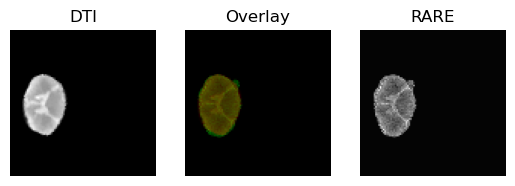

In [ ]:
import matplotlib.pyplot as plt
from dipy.viz import regtools

# Create a larger figure
fig = plt.figure(figsize=(100, 100))  # Adjust size as needed

# Overlay images with larger figure
regtools.overlay_slices(
    DTI_combined_preproc_trans_masked_rotated[:, :, :, 0],
    RARE_combined_masked_rotated_downsized,
    slice_index=None,
    slice_type=2,
    ltitle="DTI",
    rtitle="RARE",
)

# Save with high resolution (300 DPI for print-quality, increase if needed)
plt.savefig("figures/dti_rare_overlay_highres.jpg", dpi=300, bbox_inches='tight')

# Show the image
plt.show()


In [23]:
import numpy as np
from skimage.metrics import normalized_mutual_information as nmi

# Ensure both images have the same shape
b0_image = DTI_combined_preproc_trans_masked_rotated[:, :, :, 0]  # Extract b=0 image
rare_image = RARE_combined_masked_rotated_downsized

# Flatten images to 1D arrays for computing MI
b0_flat = b0_image.ravel()
rare_flat = rare_image.ravel()

# Compute Mutual Information
mi_score = nmi(b0_flat, rare_flat)
print(f"Mutual Information: {mi_score}")


Mutual Information: 1.2501459168804883


## Stiching Images Together Using Registration

## Register dwMRI and T2w struc images together

2. Load the dMRI and T2-weighted Images
Load the diffusion-weighted MRI (dMRI) and the T2-weighted image.  

3. Reslice Images (Optional)
Ensure that the voxel sizes of the two images are comparable. If they differ, reslice one of the images to match the other's voxel resolution.

4. Perform Affine Registration
Affine registration aligns the T2 image to the b0 image using a multi-step approach (translation, rigid, and affine transformations).

5. Apply the Affine Transformation
Use the affine transformation to align the T2 image to the dMRI space.

6. (Optional) Refine with Nonlinear Registration
For finer alignment, use nonlinear registration with SymmetricDiffeomorphicRegistration.

# Register The Two Images together;

## **Rotated Images**

In [ ]:
### Rotated Images
dwMRI = ants.image_read("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
t2 = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz")
#RARE_preproc_combined_blend_trans = ants.image_read("Combined_Data/Rotated and Transposed/RARE_preproc_combined_blend_trans.nii.gz")

print(f"shape of dwMRI: {dwMRI.shape}")
print(f"shape of T2: {t2.shape}")
#print(f"shape of T2 blend: {RARE_preproc_combined_blend_trans.shape}")

## B0 image
b0_mean = np.mean(dwMRI.numpy()[:, :, :, 0:3],axis = 3)
direction_clean_B = np.array(dwMRI.direction[:3, :3], dtype=np.float64, order='C')
b0_mean_ants = ants.from_numpy(b0_mean, spacing=dwMRI.spacing[:3], origin=dwMRI.origin[:3], direction = direction_clean_B)

ants.image_write(image = b0_mean_ants, filename =  "Combined_Data/Rotated and Transposed/B0_mean.nii.gz")


plt.subplot(1,2,1)
plt.imshow(b0_mean[:, :, z], cmap='gray')

plt.subplot(1,2,2)
plt.imshow(t2.numpy()[:, :, z], cmap='gray')

shape of dwMRI: (96, 96, 1965, 83)
shape of T2: (384, 384, 1965)


In [ ]:
dwMRI_corrected = ants.image_read("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated_BFC_corrected20.nii.gz")
dwMRI = ants.image_read("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
t2_corrected = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated_BFC_corrected20.nii.gz")

print(f"shape of dwMRI: {dwMRI_corrected.shape}")
print(f"shape of T2: {t2_corrected.shape}")

In [3]:
t2 = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz")
finn = ants.resample_image(t2,(200,200, t2.shape[2]),True,0)

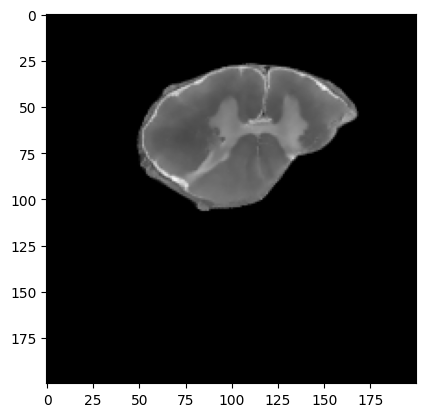

In [8]:
plt.imshow(finn.numpy()[:, :, 50], cmap='gray')

In [22]:
moving = t2
fixed = b0_mean_ants

# (B) Resample T2 to fixed grid for registration (optimization happens here)
moving_rs = ants.resample_image_to_target(moving, fixed, interp_type='linear')

# (C) Rigid registration (MI by default)
rig = ants.registration(fixed=fixed, moving=moving_rs, type_of_transform="Rigid")

# (D) Apply the *same* transform to the original high-res T2, but land it on the fixed grid:
t2_in_dwi = ants.apply_transforms(
    fixed=fixed,             # target grid (96×96×1980)
    moving=moving,           # original T2 (386×386×1980)
    transformlist=rig['fwdtransforms'],
    interpolator='linear' 
)
####
b0_in_t2 = ants.apply_transforms(
    fixed = moving,                  # target grid = original T2 (full res)
    moving = fixed ,
    transformlist=rig['invtransforms'],
    interpolator='linear'
)
ants.image_write(image = b0_in_t2, filename =  "Combined_Data/Rotated and Transposed/B0_in_T2.nii.gz")


### # Load the rigid transform #####
rigid = ants.read_transform(rig['fwdtransforms'][0])
params = rigid.parameters  # list of 12 floats

rotations_deg = np.array(params[0:9]) * 180 / np.pi
translations_mm = np.array(params[9:12])
print("Rotation (deg):", rotations_deg)
print("Translation (mm):", translations_mm)

Rotation (deg): [ 5.72935392e+01  5.06850836e-01 -5.81581770e-03 -5.06851636e-01
  5.72935392e+01 -7.85809846e-03  5.74607548e-03  7.90923900e-03
  5.72957795e+01]
Translation (mm): [-0.00566596  0.00578615 -0.03779602]


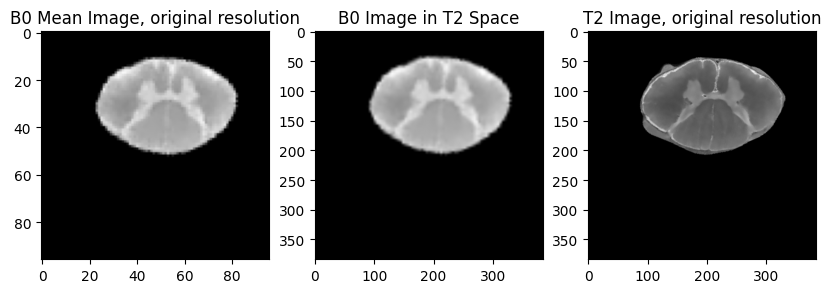

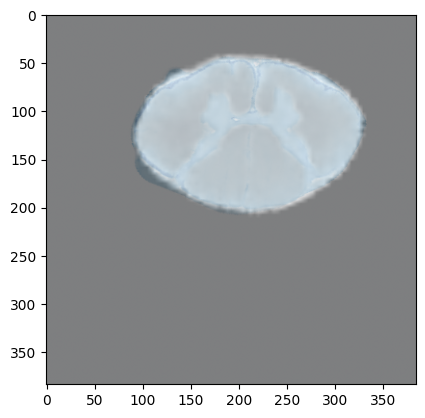

In [23]:
z = 70

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(b0_mean[:, :, z], cmap='gray')
plt.title("B0 Mean Image, original resolution")

plt.subplot(1, 3, 2)
plt.imshow(b0_in_t2.numpy()[:, :, z], cmap='gray')
plt.title("B0 Image in T2 Space")

plt.subplot(1, 3, 3)
plt.imshow(moving.numpy()[:, :, z], cmap='gray')
plt.title("T2 Image, original resolution")
plt.show()


plt.imshow(moving.numpy()[:, :, z], cmap='Blues', alpha=.5)
plt.imshow(b0_in_t2.numpy()[:, :, z], cmap='gray', alpha=.5)
plt.show()

## **Non-Rotated Images**

In [3]:
dwMRI= ants.image_read("Combined_Data/Transposed/DTI_combined_preproc_trans_masked_BFC_corrected20.nii.gz")

RARE_preproc_combined_trans = ants.image_read("Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked.nii.gz")

RARE_preproc_combined_corrected_trans= ants.image_read("Combined_Data/Transposed/RARE_combined_trans_denoised_gibbs_masked_BFC_corrected20.nii.gz")



print(f"shape of dwMRI: {dwMRI.shape}")
print(f"shape of T2: {RARE_preproc_combined_trans.shape}")
print(f"shape of T2 BFC corrected: {RARE_preproc_combined_corrected_trans.shape}")


b0_mean = np.mean(dwMRI.numpy()[:, :, :, 0:3],axis = 3)
direction_clean_B = np.array(dwMRI.direction[:3, :3], dtype=np.float64, order='C')

b0_mean_ants = ants.from_numpy(b0_mean, spacing=dwMRI.spacing[:3], origin=dwMRI.origin[:3], direction = direction_clean_B)

shape of dwMRI: (96, 96, 1965, 83)
shape of T2: (384, 384, 1965)
shape of T2 BFC corrected: (384, 384, 1965)


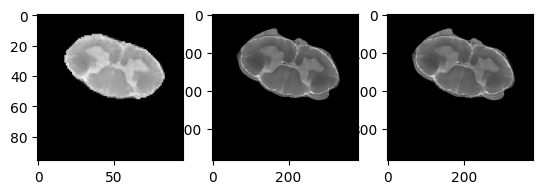

In [5]:
z = 200
plt.subplot(1,3,1)
plt.imshow(b0_mean[:, :, z], cmap='gray')

plt.subplot(1,3,2)
plt.imshow(RARE_preproc_combined_trans.numpy()[:, :, z], cmap='gray')

plt.subplot(1,3,3)
plt.imshow(RARE_preproc_combined_corrected_trans.numpy()[:, :, z], cmap='gray')

In [6]:
moving = RARE_preproc_combined_corrected_trans
fixed = b0_mean_ants

# (B) Resample T2 to fixed grid for registration (optimization happens here)
moving_rs = ants.resample_image_to_target(moving, fixed, interp_type='linear')

# (C) Rigid registration (MI by default)
rig = ants.registration(fixed=fixed, moving=moving_rs, type_of_transform="Rigid")

# (D) Apply the *same* transform to the original high-res T2, but land it on the fixed grid:
t2_in_dwi = ants.apply_transforms(
    fixed=fixed,             # target grid (96×96×1980)
    moving=moving,           # original T2 (386×386×1980)
    transformlist=rig['fwdtransforms'],
    interpolator='linear' 
)
ants.image_write(image = t2_in_dwi, filename =  "Combined_Data/Transposed/T2_in_DWI.nii.gz")

####
b0_in_t2 = ants.apply_transforms(
    fixed = moving,                  # target grid = original T2 (full res)
    moving = fixed ,
    transformlist=rig['invtransforms'],
    interpolator='linear'
)
ants.image_write(image = b0_in_t2, filename =  "Combined_Data/Transposed/B0_in_T2.nii.gz")


### # Load the rigid transform #####
rigid = ants.read_transform(rig['fwdtransforms'][0])
params = rigid.parameters  # list of 12 floats

rotations_deg = np.array(params[0:9]) * 180 / np.pi
translations_mm = np.array(params[9:12])
print("Rotation (deg):", rotations_deg)
print("Translation (mm):", translations_mm)

Rotation (deg): [ 5.72951614e+01  2.65841528e-01 -1.28918505e-04 -2.65841528e-01
  5.72951614e+01  2.57483520e-03  1.40863871e-04 -2.57420925e-03
  5.72957795e+01]
Translation (mm): [-0.01557488  0.00116218 -0.03034973]


In [141]:
from scipy import ndimage as ndi
def zshow(ax, img, z, title="", vmin=None, vmax=None):
    """Show axial slice z from ANTsImage with consistent contrast."""
    arr = img.numpy()[:, :, z]
    if vmin is None or vmax is None:
        lo, hi = np.percentile(arr, [0.5, 99.5])
    else:
        lo, hi = vmin, vmax
    ax.imshow(arr.T, origin='lower', cmap='gray', vmin=lo, vmax=hi)
    ax.set_title(title); ax.axis('off')
    return lo, hi

def checkerboard(fixed_arr, moving_arr, tiles=8):
    """Return a checkerboard blend of two 2D arrays."""
    h, w = fixed_arr.shape
    cb = np.zeros_like(fixed_arr)
    tile_h, tile_w = h // tiles, w // tiles
    for i in range(tiles):
        for j in range(tiles):
            y0, y1 = i*tile_h, (i+1)*tile_h if i < tiles-1 else h
            x0, x1 = j*tile_w, (j+1)*tile_w if j < tiles-1 else w
            if (i + j) % 2 == 0:
                cb[y0:y1, x0:x1] = fixed_arr[y0:y1, x0:x1]
            else:
                cb[y0:y1, x0:x1] = moving_arr[y0:y1, x0:x1]
    return cb

def sobel_edges(arr2d):
    """Simple edge map."""
    sx = ndi.sobel(arr2d, axis=0, mode='reflect')
    sy = ndi.sobel(arr2d, axis=1, mode='reflect')
    mag = np.hypot(sx, sy)
    mag /= (mag.max() + 1e-8)
    return mag

def img_slice_phys_coords(img, z):
    """Physical coords (mm) grid for slice z (x fast, y slow)."""
    ny, nx = img.shape[1], img.shape[0]  # ANTsImage: shape=(x,y,z)
    spacing = np.array(img.spacing)
    origin  = np.array(img.origin)
    direction = np.array(img.direction).reshape(3,3)

    # build voxel index grid (x,y,z)
    xs = np.arange(img.shape[0])
    ys = np.arange(img.shape[1])
    X, Y = np.meshgrid(xs, ys, indexing='xy')
    Z = np.full_like(X, z)
    ijk = np.stack([X, Y, Z], axis=-1).reshape(-1, 3).astype(float)

    # index->mm: origin + direction @ (ijk*spacing)
    phys = origin + (direction @ (ijk * spacing).T).T
    return phys.reshape(ys.size, xs.size, 3)

def displacement_quiver(transform_paths, img, z, step=6, in_voxels=False):
    """
    Sample displacement at a slice z on a coarse grid and return quiver fields.
    """
    # physical coords of slice
    phys = img_slice_phys_coords(img, z)   # shape (Y,X,3)
    H, W, _ = phys.shape

    # subsample grid
    yy = np.arange(0, H, step)
    xx = np.arange(0, W, step)
    P = phys[yy[:,None], xx[None,:], :].reshape(-1, 3)

    import pandas as pd
    pts_df = pd.DataFrame(P, columns=['x','y','z'])
    moved_df = ants.apply_ants_transform_to_points(3, pts_df, transform_paths)
    moved = moved_df[['x','y','z']].values

    disp_mm = moved - P
    if in_voxels:
        spacing = np.array(img.spacing)
        disp = disp_mm / spacing  # per-axis voxel displacement
    else:
        disp = disp_mm

    # reshape to (Ysub, Xsub, 3)
    Ysub, Xsub = len(yy), len(xx)
    disp = disp.reshape(Ysub, Xsub, 3)

    # Convert to quiver components in image display coordinates:
    # we show X (columns) on horizontal axis and Y (rows) on vertical axis.
    U = disp[:, :, 0]   # x-component
    V = disp[:, :, 1]   # y-component

    return xx, yy, U, V, np.linalg.norm(disp[:, :, :2], axis=2)

# --------------------------
# PLOTS
# --------------------------
def plot_registration_changes(fixed, moving, registered, rig, z=None, tiles=8, step=6):
    if z is None:
        z = fixed.shape[2] // 2

    fig = plt.figure(figsize=(14, 12))

    # A) Checkerboard: fixed vs registered
    ax1 = plt.subplot(2,2,1)
    f2d = fixed.numpy()[:, :, z].T
    r2d = registered.numpy()[:, :, z].T

    # normalize contrast to same window
    f_lo, f_hi = np.percentile(f2d, [0.5, 99.5])
    r_lo, r_hi = np.percentile(r2d, [0.5, 99.5])
    lo, hi = min(f_lo, r_lo), max(f_hi, r_hi)
    f2d_n = np.clip((f2d - lo) / (hi - lo + 1e-8), 0, 1)
    r2d_n = np.clip((r2d - lo) / (hi - lo + 1e-8), 0, 1)

    cb = checkerboard(f2d_n, r2d_n, tiles=tiles)
    ax1.imshow(cb, origin='lower', cmap='gray')
    ax1.set_title(f"Checkerboard (fixed vs registered)  |  slice z={z}")
    ax1.axis('off')

    # B) Edge overlay: fixed edges over registered
    ax2 = plt.subplot(2,2,2)
    edges = sobel_edges(f2d_n)  # edges from fixed
    ax2.imshow(r2d_n, origin='lower', cmap='gray')
    ax2.imshow(edges, origin='lower', alpha=0.6)  # overlay edges
    ax2.set_title("Fixed edges over Registered moving")
    ax2.axis('off')

    # C) Difference map |registered - fixed|
    ax3 = plt.subplot(2,2,3)
    diff = np.abs(r2d_n - f2d_n)
    ax3.imshow(diff, origin='lower', cmap='gray')
    ax3.set_title("Absolute difference (normalized contrast)")
    ax3.axis('off')

    # D) Displacement quiver (mm) on this slice
    ax4 = plt.subplot(2,2,4)
    xx, yy, U, V, mag = displacement_quiver(rig['fwdtransforms'], fixed, z, step=step, in_voxels=False)
    ax4.imshow(r2d_n, origin='lower', cmap='gray')
    # Note: quiver expects X,Y coords as meshgrid in display coordinates
    Xg, Yg = np.meshgrid(xx, yy)
    ax4.quiver(Xg, Yg, U, V, angles='xy', scale_units='xy', scale=1.0, width=0.002)
    ax4.set_title("Displacement field (mm) — subsampled")
    ax4.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
plot_registration_changes(fixed, moving, t2_in_dwi, rig, z=fixed.shape[2]//2, tiles=8, step=8)

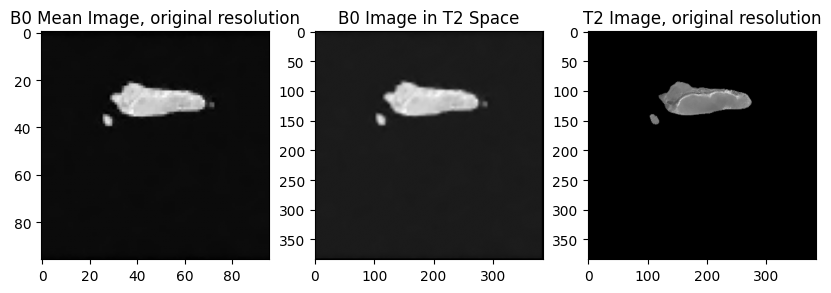

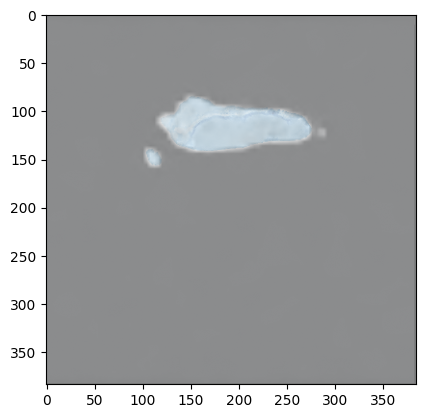

In [ ]:
z = 70

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(b0_mean[:, :, z], cmap='gray')
plt.title("B0 Mean Image, original resolution")

plt.subplot(1, 3, 2)
plt.imshow(b0_in_t2.numpy()[:, :, z], cmap='gray')
plt.title("B0 Image in T2 Space")

plt.subplot(1, 3, 3)
plt.imshow(moving.numpy()[:, :, z], cmap='gray')
plt.title("T2 Image, original resolution")
plt.show()


plt.imshow(moving.numpy()[:, :, z], cmap='Blues', alpha=.5)
plt.imshow(b0_in_t2.numpy()[:, :, z], cmap='gray', alpha=.5)
plt.show()

# Crop The Images
I have decided not to crop the images as it took too much time to figure out to esnure the same crop for both dwMRI and T2 with different resoultions without loosing the images allignment. 

## Rotated Image

In [24]:
b0_in_t2, affine_b0_in_t2 = load_nifti("Combined_Data/Rotated and Transposed/B0_in_T2.nii.gz")
b0_mean, affine_b0_mean = load_nifti("Combined_Data/Rotated and Transposed/B0_mean.nii.gz")

dwMRI, affine_dwMRI = load_nifti("Combined_Data/Rotated and Transposed/DTI_combined_preproc_trans_masked_rotated.nii.gz")
t2, affine_t2 = load_nifti("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz")

### Z-Crop

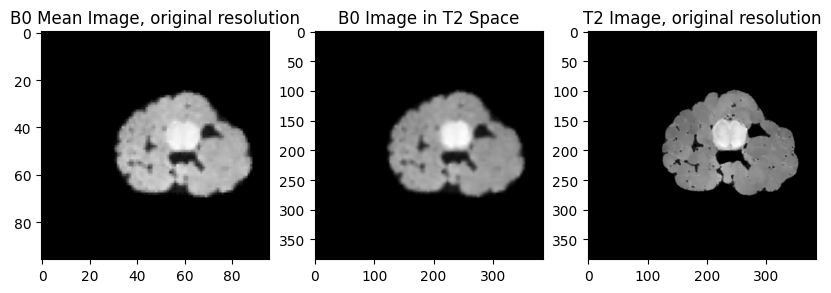

In [77]:
z_min = 20
z_max = -140
z = -140

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(b0_mean[:, :, z], cmap='gray')
plt.title("B0 Mean Image, original resolution")

plt.subplot(1, 3, 2)
plt.imshow(b0_in_t2[:, :, z], cmap='gray')
plt.title("B0 Image in T2 Space")

plt.subplot(1, 3, 3)
plt.imshow(t2[:, :, z], cmap='gray')
plt.title("T2 Image, original resolution")
plt.show()

In [ ]:
from scipy import ndimage as ndi

# img = your ANTsImage

arr = ants.image_read("Combined_Data/Rotated and Transposed/RARE_combined_trans_denoised_gibbs_masked_rotated.nii.gz")

arr_zsubset = arr[:,:,:-140]

# 1) Rough mask from intensity (Otsu threshold or fixed percentile)
RARE_combined_masked, mask = median_otsu(arr_zsubset.numpy(), median_radius=2, numpass=4,
                                    autocrop=False, dilate=None)

### X-Y Crop

In [ ]:
# Bounding box in X,Y

mask = mask[:,:,:-300]

# 2) Keep the largest connected component (the cord)
labels, nlab = ndi.label(mask)
sizes = ndi.sum(mask, labels, range(nlab+1))
largest_label = np.argmax(sizes[1:]) + 1  # skip background
mask = (labels == largest_label).astype(np.uint8)

# 3) Dilate a little to keep margin
mask_dilated = ndi.binary_dilation(mask, iterations=5)


coords = np.array(np.nonzero(mask))
min_x, max_x = coords[0].min() , coords[0].max()
min_y, max_y = coords[1].min()+2, coords[1].max()+2



size_diff = (max_y - min_y) - (max_x - min_x)
pad_in_x = size_diff // 2
start_x = max(min_x - pad_in_x, 0)
remaining_pad_in_x = size_diff - (min_x - start_x)
end_x = min(max_x + remaining_pad_in_x + 1 , arr.shape[0] - 1)

cropped_arr = arr[start_x:end_x, min_y:max_y + 1, :]


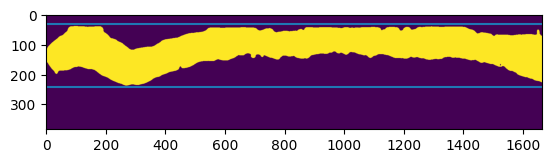

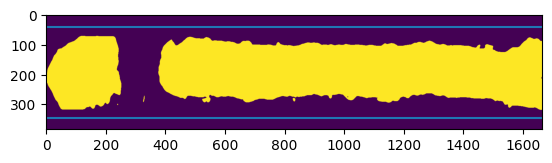

In [101]:
plt.imshow(mask[:,140,:])
plt.axhline(y = min_x)
plt.axhline(y = max_x)
plt.show()


plt.imshow(mask[90,:,:])
plt.axhline(y = min_y)
plt.axhline(y = max_y)
plt.show()

## Non Rotated Image

In [ ]:
dwMRI, affine_dwMRI = load_nifti("Combined_Data/Transposed/DTI_combined_preproc_trans.nii.gz")
RARE_preproc_combined_trans, affine_RARE = load_nifti("Combined_Data/Transposed/RARE_preproc_combined_trans.nii.gz")
RARE_preproc_combined_blend_trans, affine = load_nifti("Combined_Data/Transposed/RARE_preproc_combined_blend_trans.nii.gz")
b0_in_t2, affine = load_nifti("Combined_Data/Transposed/B0_in_T2.nii.gz")

print(f"shape of dwMRI: {dwMRI.shape}")
print(f"shape of T2: {RARE_preproc_combined_trans.shape}")
print(f"shape of T2 blend: {RARE_preproc_combined_blend_trans.shape}")
print(f"shape of B0 in T2: {b0_in_t2.shape}")


b0_mean = np.mean(dwMRI[:, :, :, 0:3],axis = 3)


shape of dwMRI: (96, 96, 2040, 83)
shape of T2: (384, 384, 2040)
shape of T2 blend: (384, 384, 2040)
shape of B0 in T2: (384, 384, 2040)


### The Z-Direction

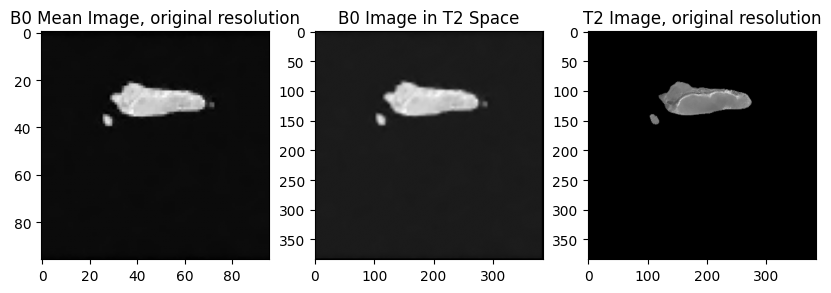

In [11]:
z_min = 70
z_max = -120
z = 70

plt.figure(figsize=(10, 5))
plt.subplot(1, 3, 1)
plt.imshow(b0_mean[:, :, z], cmap='gray')
plt.title("B0 Mean Image, original resolution")

plt.subplot(1, 3, 2)
plt.imshow(b0_in_t2[:, :, z], cmap='gray')
plt.title("B0 Image in T2 Space")

plt.subplot(1, 3, 3)
plt.imshow(RARE_preproc_combined_trans[:, :, z], cmap='gray')
plt.title("T2 Image, original resolution")
plt.show()


In [15]:
### Subet the Z-axis of the various images!! #### 
dwMRI_subset = dwMRI[:, :, z_min:z_max,:]
b0_mean_subset = b0_mean[:, :, z_min:z_max]

# Non-Blend Combined 
RARE_preproc_combined_trans_subset = RARE_preproc_combined_trans[:,:,z_min:z_max]
#Blend Combined
RARE_preproc_combined_blend_trans_subset = RARE_preproc_combined_blend_trans[:,:,z_min:z_max]

In [14]:
save_nifti(fname = "Combined_Data/Transposed/Subset/DTI_combined_preproc_trans.nii.gz",
            data = dwMRI_subset,
            affine = affine_dwMRI)

save_nifti(fname = "Combined_Data/Transposed/Subset/B0_in_T2.nii.gz",
            data = b0_mean_subset, 
            affine= affine_RARE)

save_nifti(fname = "Combined_Data/Transposed/Subset/RARE_preproc_combined_trans.nii.gz",
            data = RARE_preproc_combined_trans_subset,
            affine = affine_RARE)

save_nifti(fname = "Combined_Data/Transposed/Subset/RARE_preproc_combined_blend_trans.nii.gz",
            data = RARE_preproc_combined_trans_subset,
            affine = affine_RARE)


### Crop Image to 200x200

In [ ]:
from scipy import ndimage as ndi

# img = your ANTsImage
temp_rare = ants.image_read("Combined_Data/Transposed/RARE_preproc_combined_trans.nii.gz")

arr = ants.from_numpy(RARE_preproc_combined_trans_subset,
                       origin=temp_rare.origin,
                       spacing=temp_rare.spacing, 
                       direction=temp_rare.direction)

# 1) Rough mask from intensity (Otsu threshold or fixed percentile)

RARE_combined_masked, mask = median_otsu(arr.numpy(), median_radius=2, numpass=2,
                                    autocrop=False, dilate=None)

# 2) Keep the largest connected component (the cord)
labels, nlab = ndi.label(mask)
sizes = ndi.sum(mask, labels, range(nlab+1))
largest_label = np.argmax(sizes[1:]) + 1  # skip background
mask = (labels == largest_label).astype(np.uint8)

# 3) Dilate a little to keep margin
mask_dilated = ndi.binary_dilation(mask, iterations=5)


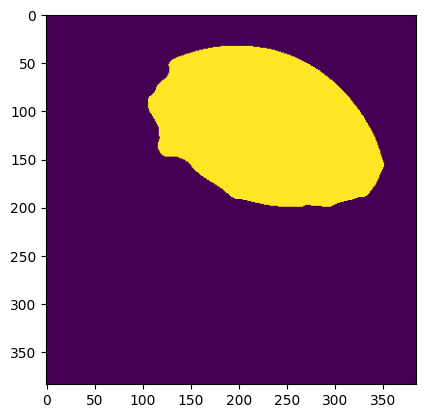

In [225]:
plt.imshow(mask[:,:,100])

In [ ]:
# Bounding box in X,Y
coords = np.array(np.nonzero(mask))
min_x, max_x = coords[0].min(), coords[0].max()
min_y, max_y = coords[1].min(), coords[1].max()

cropped_arr = arr[min_x:max_x, min_y:max_y, :]

In [ ]:
plot_all_slices(data = cropped_arr.numpy(), increment = 5)

In [ ]:
# Bounding box in X,Y
coords = np.array(np.nonzero(mask))
min_x, max_x = coords[0].min(), coords[0].max()
min_y, max_y = coords[1].min(), coords[1].max()

cropped_arr = arr[min_x:max_x, min_y:max_y, :]

# Center of bounding box
cx = (min_x + max_x) // 2
cy = (min_y + max_y) // 2

# Desired half size for 200x200 crop
half = 100

# Crop ranges — ensure they stay within image bounds
start_x = max(cx - half, 0)
end_x   = min(cx + half, arr.shape[0])
start_y = max(cy - half, 0)
end_y   = min(cy + half, arr.shape[1])

# Apply crop to numpy array
cropped_arr = arr[start_x:end_x, start_y:end_y, :]

# Back to ANTsImage (keep geometry)
#cropped_img = ants.from_numpy(cropped_arr,
#                              origin=arr.origin,
#                              spacing=arr.spacing,
#                              direction=arr.direction)


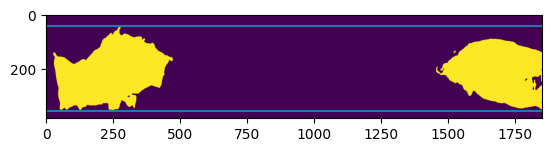

In [ ]:
plt.imshow(mask[180,:,:])
plt.axhline(y = min_y)
plt.axhline(y = max_y)
plt.show()

plt.imshow(mask[:,150,:])
plt.axhline(y = min_x)
plt.axhline(y = max_x)


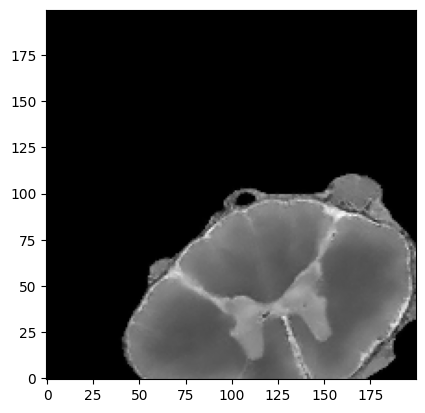

In [222]:
import matplotlib.pyplot as plt
mid_z = cropped_arr.shape[2] // 2
plt.imshow(cropped_arr.numpy()[:, :, mid_z], origin='lower', cmap='gray')
plt.show()
